![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [83]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import rankdata

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [84]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [85]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [86]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [88]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [89]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [90]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [91]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [92]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [93]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [95]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
33917,id_607,Oporto,"['Portuguese', 'European', 'Contemporary', 'Ve...",608.0,$,57.0,"[['Delicious lunch', 'Amazing and super cute p...",/Restaurant_Review-g189180-d7623797-Reviews-Th...,d7623797,1,4.0
35977,id_5268,Milan,['Italian'],5271.0,NaN,9.0,"[['poor atmosphere, good food'], ['07/21/2009']]",/Restaurant_Review-g187849-d1073667-Reviews-Os...,d1073667,1,3.5
43309,id_2106,Berlin,['Italian'],2108.0,$$ - $$$,34.0,"[['Beautiful atmosphere, delicious food.', '""O...",/Restaurant_Review-g187323-d2307832-Reviews-Tr...,d2307832,1,4.5
32892,id_299,London,"['French', 'European', 'Vegetarian Friendly', ...",300.0,$$ - $$$,545.0,"[['Good for a Group', 'Great food and friendly...",/Restaurant_Review-g186338-d1385620-Reviews-Br...,d1385620,1,4.0
38151,id_1075,Copenhagen,NaN,1077.0,NaN,15.0,"[['Close to five stars', 'Almost perfect'], ['...",/Restaurant_Review-g189541-d12474539-Reviews-M...,d12474539,1,4.0


In [96]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

#### Определяем полезные функции

In [97]:
# Построение гистограммы и вывод основных статистических данных цифровых признаков
def numerical_data_value(col):
    
    display(data[col].hist(bins=100))
    display(data[col].describe())

# Построение гистограммы цифровых признаков с выбросами, а также вывод границ выбросов
def numerical_hist(col, end):

    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l_side = perc25 - 1.5*IQR
    r_side = perc75 + 1.5*IQR
    print('25 percentile: {}'.format(perc25),
          '\n75 percentile: {}'.format(perc75),
          '\nData Outlier Boundaries:',
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side))
    data[col].loc[data[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]\
        .hist(bins=100, range=(0, end), label='Значения')
    data[col].loc[data[col] >= r_side].hist(alpha=0.5, bins=100, range=(0, end),
                                        label='Выбросы')
    plt.legend()
    
# Нормализация признака
def normalise_col(column):

    scaler = MinMaxScaler()
    get_column = pd.DataFrame(data[column])
    get_column_norm = scaler.fit_transform(get_column)
    return get_column_norm

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Определим наличие и распределение NAN
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [98]:
#Находим колонки с пропусками
data.info()

cols_with_missing = ['Cuisine Style', 'Price Range', 'Number of Reviews']
for col in cols_with_missing:
    data[col + '_isNAN'] = data[col].isna().astype('uint8')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [99]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN
5675,id_5675,Paris,NaN,10976.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187147-d5873391-Reviews-Di...,d5873391,0,0.0,1,1,1
15711,id_2580,London,"['Japanese', 'Fast Food', 'Sushi', 'Asian', 'V...",2585.0,$,117.0,"[['Quick, easy, fresh', 'Visit to London'], ['...",/Restaurant_Review-g186338-d3265856-Reviews-It...,d3265856,1,4.0,0,0,0
17777,id_840,Geneva,['Asian'],845.0,NaN,8.0,"[['Probably the best restaurant in Geneva'], [...",/Restaurant_Review-g188057-d1044836-Reviews-4_...,d1044836,1,4.0,0,1,0
48525,id_3550,Berlin,NaN,3552.0,NaN,NaN,"[['Unexpected pleasure'], ['07/19/2017']]",/Restaurant_Review-g187323-d12661577-Reviews-C...,d12661577,1,5.0,1,1,1
18434,id_6361,London,"['Asian', 'Korean', 'Vegetarian Friendly']",6370.0,$$ - $$$,115.0,"[['Great Korean bite in Clapham / Battersea', ...",/Restaurant_Review-g186338-d3650406-Reviews-Ha...,d3650406,1,4.0,0,0,0


## 2. Обработка признаков и заполнение пропусков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [100]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Cuisine Style_isNAN            2
Price Range_isNAN              2
Number of Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

### 2.1 Price Range

In [101]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3

In [102]:
# Обработка 'Price Range'
def Price_Range(value):
    if value == '$':
        return 1
    if value == '$$ - $$$':
        return 2
    if value == '$$$$':
        return 3
    return np.nan


data['Price Range'] = data['Price Range'].apply(Price_Range)
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN
14445,id_1955,Milan,"['Italian', 'Seafood', 'Mediterranean', 'Veget...",1957.0,2.0,245.0,"[['great sicilian, high quality', 'poor restau...",/Restaurant_Review-g187849-d2144872-Reviews-Tr...,d2144872,1,4.0,0,0,0
10258,id_50,Rome,"['Italian', 'Street Food', 'Brew Pub']",51.0,1.0,1068.0,"[['Delicious, even for someone who doesn’t li....",/Restaurant_Review-g187791-d6603135-Reviews-An...,d6603135,1,4.5,0,0,0
20764,id_5535,Milan,NaN,5538.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d8338615-Reviews-Ta...,d8338615,1,3.0,1,1,0
31029,id_4062,Rome,"['Italian', 'Mediterranean']",4063.0,2.0,53.0,"[['Great spot', 'A real Italian experience'], ...",/Restaurant_Review-g187791-d3940678-Reviews-Ho...,d3940678,1,4.0,0,0,0
46325,id_13500,London,"['Turkish', 'Middle Eastern', 'Lebanese', 'Med...",13510.0,2.0,30.0,"[['Lovely food', 'Standard Fare'], ['12/17/201...",/Restaurant_Review-g186338-d3419584-Reviews-Me...,d3419584,1,3.0,0,0,0


In [103]:
# Посмотрим на распределение модальных значений переменной.
data.groupby(['City'])['Price Range'].agg(pd.Series.mode).value_counts()

2.0    31
Name: Price Range, dtype: int64

Поскольку во всех городах модальный ценовой диапозон одинаковый, пропуски можно заполнить модальным значением.

In [104]:
# Заполним NAN средней ценой по ресторанам.
data['Price Range'] = data['Price Range'].fillna(data['Price Range'].mode()[0])

In [105]:
# Добавим переменную соотношение цен в ресторане и средней цены
data['price_factor'] = data['Price Range']/data['Price Range'].mode()[0]
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN,price_factor
20384,id_4487,Berlin,NaN,4489.0,2.0,3.0,"[[], []]",/Restaurant_Review-g187323-d12702853-Reviews-T...,d12702853,1,4.5,1,1,0,1.0
1994,id_1994,London,['Chinese'],10383.0,2.0,7.0,"[['Amazing takeaway', 'Yum'], ['04/05/2017', '...",/Restaurant_Review-g186338-d7136275-Reviews-Ve...,d7136275,0,0.0,0,1,0,1.0
23256,id_867,Amsterdam,"['American', 'Fast Food', 'Bar', 'European', '...",869.0,2.0,84.0,"[['Awesome burgers and ""******* Everything""', ...",/Restaurant_Review-g188590-d8130149-Reviews-Ro...,d8130149,1,4.0,0,0,0,1.0
26835,id_3791,Milan,"['Italian', 'Pizza']",3793.0,1.0,35.0,"[['Pleasant meal'], ['05/01/2017']]",/Restaurant_Review-g187849-d5263020-Reviews-Tr...,d5263020,1,4.0,0,0,0,0.5
31542,id_15039,London,NaN,15050.0,2.0,2.0,"[['Standard', 'I always get the chicken burger...",/Restaurant_Review-g186338-d5122141-Reviews-Ch...,d5122141,1,3.0,1,1,0,1.0


### 2.2 Cuisine Style

In [106]:
# Заменяем пустые значения в кухнях на Local - локальная кухня
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Local']")

In [107]:
# Приведем значения к списку и посчитаем количество кухонь в ресторане
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: eval(x))
data['cuisine_style_count'] = data['Cuisine Style'].apply(lambda x: len(x))
data.sample()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN,price_factor,cuisine_style_count
42390,id_2532,Brussels,"[Belgian, European, French]",2533.0,2.0,77.0,"[['Pretty average', 'Warm welcome, great food'...",/Restaurant_Review-g188644-d966729-Reviews-L_A...,d966729,1,3.5,0,0,0,1.0,3


### 2.3 Ranking

Что бы легче было оценить признак Ranking, нормируем его относительно максимального значения в датасете.

In [108]:
data['Ranking'] = data.groupby('City')['Ranking'].apply(lambda x: x/x.max())

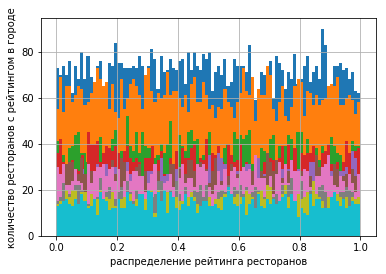

In [109]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.ylabel('количество ресторанов с рейтингом в городе')
plt.xlabel('распределение рейтинга ресторанов')
plt.show()

Рестораны с различным рейтингом равномерно распрпделены в различных городах. Чем крупнее город, тем больше ресторанов в каждой шкале рейтинга.
Добавим переменные со средним, максимальным и минимальным рангами ресторана по городу.

In [110]:
ranking_mean_per_city = data.groupby('City')['Ranking'].mean()
data['rating_mean_per_city'] = data.City.map(ranking_mean_per_city)

In [111]:
rank_city_min = data.groupby(['City'])['Ranking'].min().to_dict()
rank_city_max = data.groupby(['City'])['Ranking'].max().to_dict()
data['rank_city_min'] = data.City.map(rank_city_min)
data['rank_city_max'] = data.City.map(rank_city_max)
data['rank_norm'] = data.apply(lambda x: (
    x['Ranking'] - x['rank_city_min'])/(x['rank_city_max'] - x['rank_city_min']), axis=1)

data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN,price_factor,cuisine_style_count,rating_mean_per_city,rank_city_min,rank_city_max,rank_norm
39239,id_2836,Brussels,[Local],0.943779,2.0,6.0,"[['Poor quality seafood', 'Not the best portug...",/Restaurant_Review-g1136501-d11964412-Reviews-...,d11964412,1,2.5,1,1,0,1.0,1,0.512941,0.000998,1.0,0.943723
5295,id_5295,Brussels,"[French, Belgian, Seafood, European]",0.062874,2.0,6437.0,"[['Interesting restaurant, not sure of the fu....",/Restaurant_Review-g188644-d694788-Reviews-Che...,d694788,0,0.0,0,0,0,1.0,4,0.512941,0.000998,1.0,0.061938
39730,id_5259,Madrid,[Spanish],0.597344,1.0,12.0,"[['Cozy and great drinks!', 'Awesome place'], ...",/Restaurant_Review-g187514-d7812082-Reviews-Pi...,d7812082,1,4.0,0,0,0,0.5,1,0.498186,0.000114,1.0,0.597298
17421,id_2089,Budapest,"[European, Hungarian]",0.856557,1.0,6.0,"[['Great fröccs in a great place', 'Very overp...",/Restaurant_Review-g274887-d10240177-Reviews-T...,d10240177,1,3.5,0,0,0,0.5,2,0.499615,0.000410,1.0,0.856499
26262,id_7501,Barcelona,"[Mediterranean, European, Spanish]",0.962288,2.0,364.0,"[['Nice Outdoor Cafe on Los Ramblas', 'Avoid I...",/Restaurant_Review-g187497-d7260754-Reviews-Ku...,d7260754,1,2.5,0,0,0,1.0,3,0.497617,0.000641,1.0,0.962264


### 2.4 Reviews

In [112]:
# Заполняем NAN значения в Reviews
data['Reviews'] = data['Reviews'].fillna('[[],[]]')

# Функция для определения дат отзывов и дней между ними
def Last_Review_Date(value):
    results = []

    items = re.findall(r'\d{2}/\d{2}/\d{4}', value)
    for item in items:
        results.append(datetime.datetime.strptime(item, '%m/%d/%Y').date())
    
    minDate = np.nan if len(results) == 0 else min(results);
    maxDate = np.nan if len(results) == 0 else max(results);
    
    return (
        minDate,
        maxDate
    )

data['first_review_date'] = data['Reviews'].apply(lambda x: Last_Review_Date(x)[0])
data['last_review_date'] = data['Reviews'].apply(lambda x: Last_Review_Date(x)[1])


data['first_review_date'].fillna(min(data[data['first_review_date'].isna() == False]['first_review_date']), inplace=True)
data['last_review_date'].fillna(min(data[data['last_review_date'].isna() == False]['last_review_date']), inplace=True)
data['review_difference'] = data['last_review_date'] - data['first_review_date']

data.sample()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Number of Reviews_isNAN,price_factor,cuisine_style_count,rating_mean_per_city,rank_city_min,rank_city_max,rank_norm,first_review_date,last_review_date,review_difference
9084,id_9084,Stockholm,"[Italian, Mediterranean, European, Vegetarian ...",0.050325,2.0,244.0,[['Very friendly people and tasty food. Highl....,/Restaurant_Review-g189852-d3966986-Reviews-Il...,d3966986,0,...,0,1.0,6,0.502225,0.000406,1.0,0.049939,2017-07-09,2017-12-05,149 days


Ранжируем столбцы с датами отзывов и столбец с днями между отзывами.

In [113]:
data['rang_last_review'] = rankdata(data['last_review_date'], method='min')
data['rang_fist_review'] = rankdata(data['first_review_date'], method='min')

In [114]:
rangs = data['rang_last_review'].values
rang_matrix = np.reshape(rangs, (-1, 1))
scaler = MinMaxScaler()
data['rang_last_review'] = scaler.fit_transform(rang_matrix)

In [115]:
rangs_f = data['rang_fist_review'].values
rang_matrix_f = np.reshape(rangs_f, (-1, 1))
scaler = MinMaxScaler()
data['rang_fist_review'] = scaler.fit_transform(rang_matrix_f)

In [116]:
data['review_difference'] = rankdata(data['review_difference'], method='min')

rangs_day = data['review_difference'].values
rang_matrix_day = np.reshape(rangs_day, (-1, 1))
scaler = MinMaxScaler()
data['review_difference'] = scaler.fit_transform(rang_matrix_day)

In [117]:
# Удаляем ненужные колонки
data.drop('first_review_date', axis=1, inplace=True)
data.drop('last_review_date', axis=1, inplace=True)

data.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Number of Reviews_isNAN,price_factor,cuisine_style_count,rating_mean_per_city,rank_city_min,rank_city_max,rank_norm,review_difference,rang_last_review,rang_fist_review
0,id_0,Paris,"[Bar, Pub]",0.926855,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,1.0,2,0.496107,0.000215,1.0,0.926840,0.000000,0.000000,0.000000
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",0.092901,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,1.0,5,0.494506,0.003506,1.0,0.089710,0.535151,0.773922,0.819596
2,id_2,Edinburgh,[Vegetarian Friendly],0.458664,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,1.0,1,0.501206,0.000566,1.0,0.458357,0.464129,0.863549,0.899398


### 2.5 City

In [118]:
# Проанализируем количество ресторанов по городам
data.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

Переменная "City" является категориальной.

In [119]:
# Добавим информацию о наслении
population = {
    'London' : 8909081,
    'Paris' : 2148271,
    'Madrid' : 3223334,
    'Barcelona' : 1620343,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2860009,
    'Prague' : 1324277,
    'Lisbon' : 505526,
    'Vienna' : 2600000,
    'Amsterdam' : 872680,
    'Brussels' : 1208542,
    'Hamburg' : 1845229,
    'Munich' : 1484226,
    'Lyon' : 516092,
    'Stockholm' : 975904,
    'Budapest' : 1752286,
    'Warsaw' : 1793579,
    'Dublin' : 554554,
    'Copenhagen' : 794128,
    'Athens' : 664046,
    'Edinburgh' : 488050, 
    'Zurich' : 415215,
    'Oporto' : 287591,
    'Geneva' : 201818, 
    'Krakow' : 779115, 
    'Oslo' : 697549, 
    'Helsinki' : 656229,
    'Bratislava' : 437726,
    'Luxembourg' : 626108,
    'Ljubljana' : 295504
}

data['population'] = data.City.map(population)
data.sample()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,price_factor,cuisine_style_count,rating_mean_per_city,rank_city_min,rank_city_max,rank_norm,review_difference,rang_last_review,rang_fist_review,population
42299,id_3382,Rome,"[Italian, Pizza, Mediterranean, European]",0.568763,2.0,276.0,"[['Weekend break', 'Awesome Pizza'], ['05/12/2...",/Restaurant_Review-g187791-d6900544-Reviews-Vi...,d6900544,1,...,1.0,4,0.499451,0.000168,1.0,0.56869,0.868597,0.406992,0.374647,2860009


In [120]:
# Преобразуем City с помощью One-Hot Encoding
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"[Bar, Pub]",0.926855,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",0.092901,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,[Vegetarian Friendly],0.458664,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",0.101496,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",0.041620,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


### 2.6 Number of Reviews

25 percentile: 9.0 
75 percentile: 115.0 
Data Outlier Boundaries: 
left: -150.0 
right: 274.0


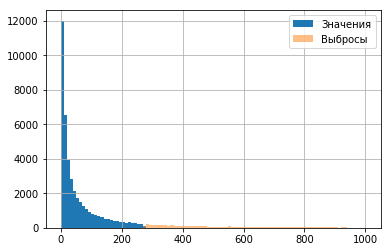

In [121]:
# Проверям на выбросы
numerical_hist('Number of Reviews', 1000)

Логарифмируем значение

In [122]:
data['number_of_reviews_log'] = np.log(data['Number of Reviews'] + 1)

median = data['number_of_reviews_log'].median()
IQR = data['number_of_reviews_log'].quantile(0.75) - data['number_of_reviews_log'].quantile(0.25)
perc25 = data['number_of_reviews_log'].quantile(0.25)
perc75 = data['number_of_reviews_log'].quantile(0.75)
l_side = perc25 - 1.5*IQR
r_side = perc75 + 1.5*IQR
print('25 percentile: {}'.format(perc25),
          '\n75 percentile: {}'.format(perc75),
          '\nData Outlier Boundaries:',
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side))

25 percentile: 2.302585092994046 
75 percentile: 4.7535901911063645 
Data Outlier Boundaries: 
left: -1.373922554174432 
right: 8.430097838274843


In [123]:
a =  data[data['number_of_reviews_log'] > 8.430097838274843].number_of_reviews_log.value_counts().sum()
print(f' после логарифмирования осталовсь {a} выбросов')

 после логарифмирования осталовсь 21 выбросов


In [124]:
data.number_of_reviews_log.mode().value_counts()

1.098612    1
dtype: int64

Заменим выбросы и отсутствующие значения модальным значением. Перед этим добавим информацию об изменения в датасет.

In [125]:
data['number_of_reviews_was_outliers'] = data['number_of_reviews_log'] >= 8.430097838274843 

In [126]:
def Number_of_reviews_log (x):
    if x > 8.430097838274843:
        return 1.098612
    elif x != x:
        return 1.098612
    else:
        return x
    
data['number_of_reviews_log'] = data['number_of_reviews_log'].apply(Number_of_reviews_log)
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,number_of_reviews_log,number_of_reviews_was_outliers
45278,id_2825,"[Italian, Pizza, Vegetarian Friendly]",0.172099,2.0,16.0,"[['Pizza as good is in Napoli', 'BEST PIZZA IN...",/Restaurant_Review-g186338-d13150793-Reviews-F...,d13150793,1,5.0,...,0,0,0,0,0,0,0,0,2.833213,False
25787,id_1404,"[Sushi, Asian, Vietnamese]",0.335721,2.0,7.0,"[['favorite Asian restaurant in Prague', 'Grea...",/Restaurant_Review-g274707-d10113620-Reviews-R...,d10113620,1,5.0,...,0,1,0,0,0,0,0,0,2.079442,False
16381,id_5221,"[Japanese, Seafood, Sushi, Asian]",0.669831,2.0,78.0,"[['Good quality/price rate', 'Never Again.'], ...",/Restaurant_Review-g187497-d2067255-Reviews-Ta...,d2067255,1,3.5,...,0,0,0,0,0,0,0,0,4.369448,False
31606,id_7990,"[Seafood, Spanish, Mediterranean]",0.907822,2.0,10.0,"[['Very good!'], ['02/12/2016']]",/Restaurant_Review-g187514-d8580956-Reviews-Ce...,d8580956,1,4.5,...,0,0,0,0,0,0,0,0,2.397895,False
47358,id_3252,[Cafe],0.778176,2.0,9.0,"[['Delish and so much more than crepes', 'Woul...",/Restaurant_Review-g274707-d5454164-Reviews-Cr...,d5454164,1,4.0,...,0,1,0,0,0,0,0,0,2.302585,False


### 2.7 Population

Добавим нормированный столбец соотношения количества отзывов на 1 человека

In [127]:
data['reviews_per_population'] = data.number_of_reviews_log / data.population

rangs_rpp = data['reviews_per_population'].values
rang_rpp_matrix = np.reshape(rangs_rpp, (-1, 1))
scaler = MinMaxScaler()
data['reviews_per_population'] = scaler.fit_transform(rang_rpp_matrix)

In [128]:
data.sample()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,number_of_reviews_log,number_of_reviews_was_outliers,reviews_per_population
27005,id_1743,"[Moroccan, Mediterranean]",0.991506,2.0,5.0,"[['mediocre', 'Closed'], ['06/28/2015', '04/24...",/Restaurant_Review-g186525-d7760501-Reviews-Ca...,d7760501,1,1.5,...,0,0,0,0,0,0,0,1.791759,False,0.097177


![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

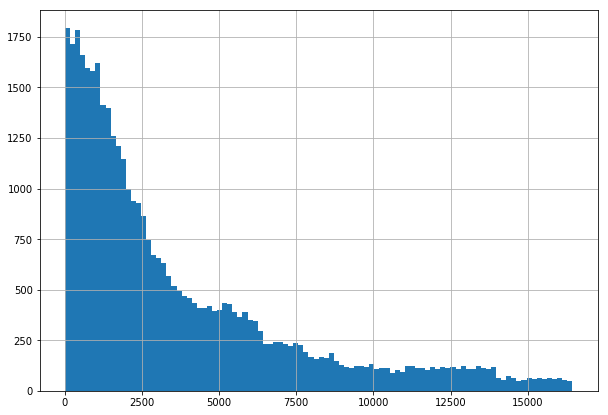

In [129]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

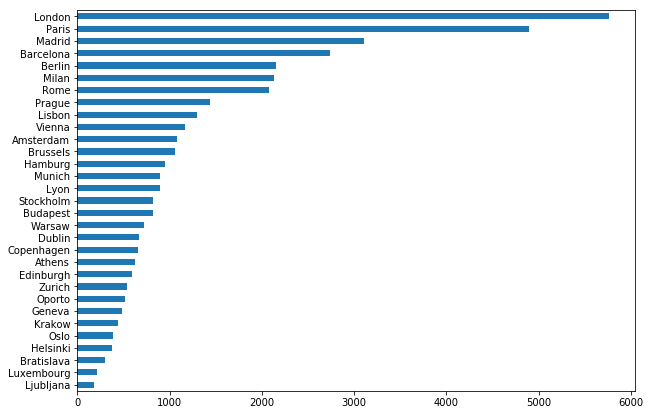

In [130]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

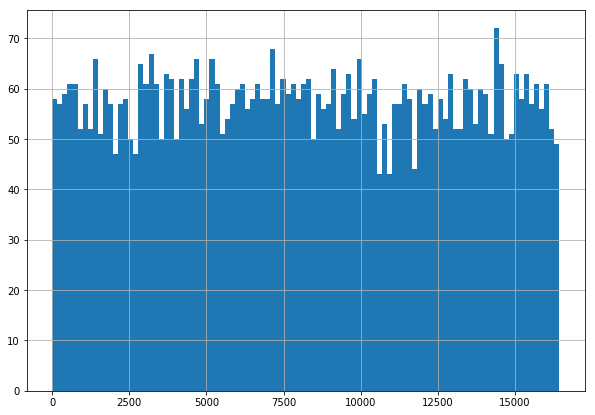

In [131]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

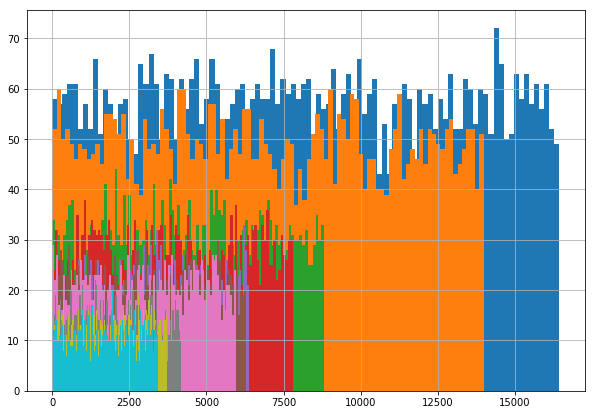

In [132]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

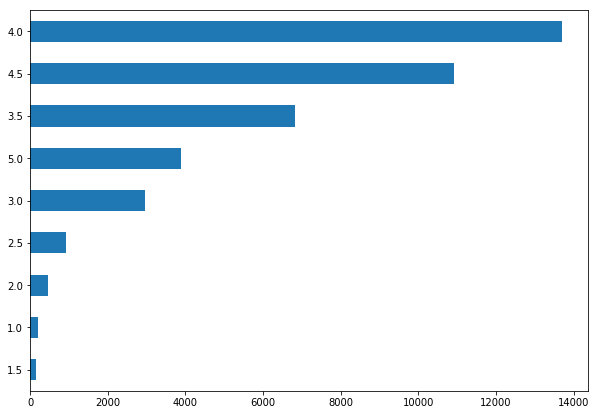

In [133]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

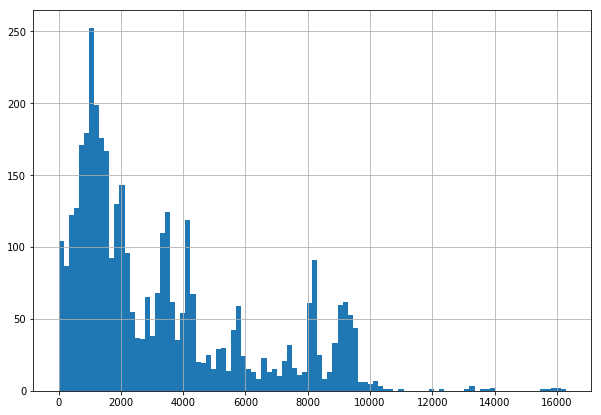

In [134]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

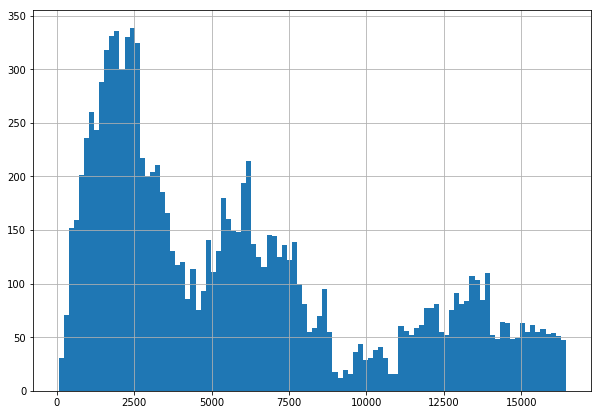

In [135]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

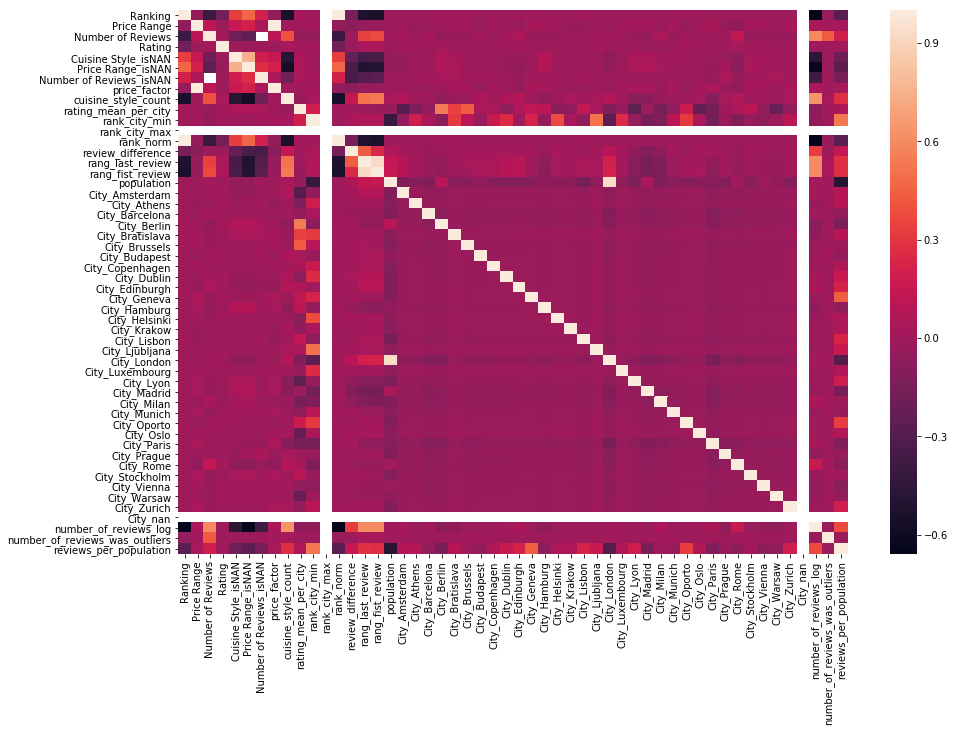

In [136]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [137]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [138]:
def preproc_data(df_input):
    # ################### Общие функции ###################
    
    # Обработка Price Range
    def Price_Range(value):
        if value == '$':
            return 1
        if value == '$$ - $$$':
            return 2
        if value == '$$$$':
            return 3
        return np.nan
    
    # Обработка Reviews
    def Last_Review_Date(value):
        results = []

        items = re.findall(r'\d{2}/\d{2}/\d{4}', value)
        for item in items:
            results.append(datetime.datetime.strptime(item, '%m/%d/%Y').date())
    
        minDate = np.nan if len(results) == 0 else min(results);
        maxDate = np.nan if len(results) == 0 else max(results);
    
        return (
            minDate,
            maxDate
        )
    
    # Обработка Number of Review
    def Number_of_reviews_log (x):
        if x > 8.430097838274843:
            return 1.098612
        elif x != x:
            return 1.098612
        else:
            return x
        
            
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','URL_TA', 'ID_TA'], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски
    df_output['price_range'] = df_output['Price Range'].apply(Price_Range)
    df_output['price_range'] = df_output['price_range'].fillna(df_output['price_range'].mode()[0])
    
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna("['Local']")
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: eval(x))
    
    df_output['Ranking'] = df_output.groupby('City')['Ranking'].apply(lambda x: x/x.max())
    
    df_output['Reviews'] = df_output['Reviews'].fillna('[[],[]]')

    # ################### 3. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    df_output['price_factor'] = df_output['price_range']/df_output['price_range'].mode()[0]
    df_output['cuisine_style_count'] = df_output['Cuisine Style'].apply(lambda x: len(x))
    
    ranking_mean_per_city = df_output.groupby('City')['Ranking'].mean()
    df_output['rating_mean_per_city'] = df_output.City.map(ranking_mean_per_city)
    
    rank_city_min = df_output.groupby(['City'])['Ranking'].min().to_dict()
    rank_city_max = df_output.groupby(['City'])['Ranking'].max().to_dict()
    df_output['rank_city_min'] = df_output.City.map(rank_city_min)
    df_output['rank_city_max'] = df_output.City.map(rank_city_max)
    df_output['rank_norm'] = df_output.apply(lambda x: (
    x['Ranking'] - x['rank_city_min'])/(x['rank_city_max'] - x['rank_city_min']), axis=1)

    df_output['first_review_date'] = df_output['Reviews'].apply(lambda x: Last_Review_Date(x)[0])
    df_output['last_review_date'] = df_output['Reviews'].apply(lambda x: Last_Review_Date(x)[1])

    df_output['first_review_date'].fillna(min(df_output[df_output['first_review_date'].isna() == False]['first_review_date']), inplace=True)
    df_output['last_review_date'].fillna(min(df_output[df_output['last_review_date'].isna() == False]['last_review_date']), inplace=True)
    df_output['review_difference'] = df_output['last_review_date'] - df_output['first_review_date']

    df_output['rang_last_review'] = rankdata(df_output['last_review_date'], method='min')
    df_output['rang_fist_review'] = rankdata(df_output['first_review_date'], method='min')

    rangs = df_output['rang_last_review'].values
    rang_matrix = np.reshape(rangs, (-1, 1))
    scaler = MinMaxScaler()
    df_output['rang_last_review'] = scaler.fit_transform(rang_matrix)

    rangs_f = df_output['rang_fist_review'].values
    rang_matrix_f = np.reshape(rangs_f, (-1, 1))
    scaler = MinMaxScaler()
    df_output['rang_fist_review'] = scaler.fit_transform(rang_matrix_f)
    
    df_output['review_difference'] = rankdata(df_output['review_difference'], method='min')
    rangs_day = df_output['review_difference'].values
    rang_matrix_day = np.reshape(rangs_day, (-1, 1))
    scaler = MinMaxScaler()
    df_output['review_difference'] = scaler.fit_transform(rang_matrix_day)

    population = {
        'London' : 8909081,
        'Paris' : 2148271,
        'Madrid' : 3223334,
        'Barcelona' : 1620343,
        'Berlin' : 3769495,
        'Milan' : 1399860,
        'Rome' : 2860009,
        'Prague' : 1324277,
        'Lisbon' : 505526,
        'Vienna' : 2600000,
        'Amsterdam' : 872680,
        'Brussels' : 1208542,
        'Hamburg' : 1845229,
        'Munich' : 1484226,
        'Lyon' : 516092,
        'Stockholm' : 975904,
        'Budapest' : 1752286,
        'Warsaw' : 1793579,
        'Dublin' : 554554,
        'Copenhagen' : 794128,
        'Athens' : 664046,
        'Edinburgh' : 488050, 
        'Zurich' : 415215,
        'Oporto' : 287591,
        'Geneva' : 201818, 
        'Krakow' : 779115, 
        'Oslo' : 697549, 
        'Helsinki' : 656229,
        'Bratislava' : 437726,
        'Luxembourg' : 626108,
        'Ljubljana' : 295504
    }
    df_output['population'] = df_output.City.map(population)
    
    df_output['number_of_reviews_log'] = np.log(df_output['Number of Reviews'] + 1)
    df_output['number_of_reviews_was_outliers'] = df_output['number_of_reviews_log'] >= 8.430097838274843 
    df_output['number_of_reviews_log'] = df_output['number_of_reviews_log'].apply(Number_of_reviews_log)
    
    df_output['reviews_per_population'] = df_output.number_of_reviews_log / df_output.population

    rangs_rpp = df_output['reviews_per_population'].values
    rang_rpp_matrix = np.reshape(rangs_rpp, (-1, 1))
    scaler = MinMaxScaler()
    df_output['reviews_per_population'] = scaler.fit_transform(rang_rpp_matrix)

    # ################### 4. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
     
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    df_output.drop(['Price Range', 'Cuisine Style', 'first_review_date', 'last_review_date', 'Number of Reviews', 'Ranking'], axis = 1, inplace=True)
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [139]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,sample,Rating,price_range,price_factor,cuisine_style_count,rating_mean_per_city,rank_city_min,rank_city_max,rank_norm,review_difference,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
48469,1,4.0,2.0,1.0,1,0.494506,0.003506,1.0,0.686895,0.895258,...,0,0,0,0,0,0,0,0,0,0
35101,1,3.0,2.0,1.0,2,0.512941,0.000998,1.0,0.893440,0.000000,...,0,0,0,0,0,0,0,0,0,0
13768,1,4.0,2.0,1.0,7,0.497617,0.000641,1.0,0.212168,0.630213,...,0,0,0,0,0,0,0,0,0,0
1012,0,0.0,2.0,1.0,1,0.496886,0.000290,1.0,0.986930,0.000000,...,0,0,0,0,0,0,1,0,0,0
27754,1,3.5,2.0,1.0,1,0.494985,0.000159,1.0,0.851610,0.000000,...,0,0,0,0,0,0,0,0,0,0
12382,1,5.0,1.0,0.5,2,0.499451,0.000168,1.0,0.633429,0.401988,...,0,0,0,0,1,0,0,0,0,0
9365,0,0.0,1.0,0.5,1,0.496107,0.000215,1.0,0.757563,0.000000,...,0,0,1,0,0,0,0,0,0,0
8720,0,0.0,2.0,1.0,2,0.489086,0.000375,1.0,0.154972,0.952199,...,0,0,0,0,0,0,0,0,0,0
8750,0,0.0,2.0,1.0,4,0.498186,0.000114,1.0,0.823342,0.000000,...,0,0,0,0,0,0,0,0,0,0
45752,1,3.5,2.0,1.0,1,0.512941,0.000998,1.0,0.843157,0.673573,...,0,0,0,0,0,0,0,0,0,0


In [140]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
sample                            50000 non-null int64
Rating                            50000 non-null float64
price_range                       50000 non-null float64
price_factor                      50000 non-null float64
cuisine_style_count               50000 non-null int64
rating_mean_per_city              50000 non-null float64
rank_city_min                     50000 non-null float64
rank_city_max                     50000 non-null float64
rank_norm                         50000 non-null float64
review_difference                 50000 non-null float64
rang_last_review                  50000 non-null float64
rang_fist_review                  50000 non-null float64
population                        50000 non-null int64
number_of_reviews_log             50000 non-null float64
number_of_reviews_was_outliers    50000 non-null bool
reviews_per_population            50000 non-n

In [141]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [142]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [143]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 47), (40000, 47), (40000, 46), (32000, 46), (8000, 46))

# Model 
Сам ML

In [144]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [145]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [146]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [147]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20051187499999998


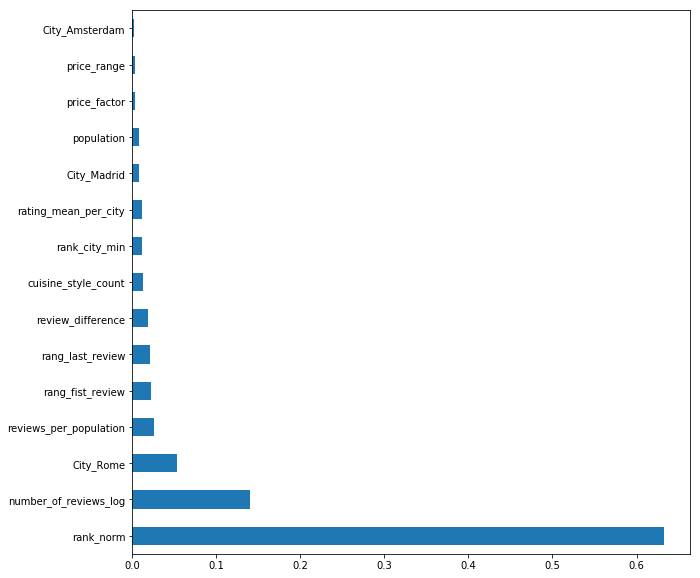

In [148]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [149]:
test_data.sample(10)

,Rating,price_range,price_factor,cuisine_style_count,rating_mean_per_city,rank_city_min,rank_city_max,rank_norm,review_difference,rang_last_review,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
3119,0.0,2.0,1.0,2,0.498186,0.000114,1.0,0.656335,0.000000,0.259755,...,0,0,0,0,0,0,0,0,0,0
1948,0.0,2.0,1.0,5,0.494985,0.000159,1.0,0.795346,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
8266,0.0,2.0,1.0,1,0.502376,0.000269,1.0,0.718245,0.750035,0.563933,...,0,0,0,0,0,0,0,0,0,0
2509,0.0,1.0,0.5,3,0.496107,0.000215,1.0,0.142602,0.401988,0.511786,...,0,0,1,0,0,0,0,0,0,0
5764,0.0,1.0,0.5,1,0.510894,0.000314,1.0,0.823077,0.000000,0.202245,...,0,0,0,0,0,0,0,0,0,0
7484,0.0,2.0,1.0,2,0.498186,0.000114,1.0,0.064033,0.632893,0.897587,...,0,0,0,0,0,0,0,0,0,0
8509,0.0,2.0,1.0,1,0.489876,0.000464,1.0,0.465397,0.920598,0.291051,...,0,0,0,0,0,0,0,1,0,0
1137,0.0,2.0,1.0,2,0.502376,0.000269,1.0,0.443219,0.960699,1.000000,...,0,0,0,0,0,0,0,0,0,0
5802,0.0,1.0,0.5,4,0.496107,0.000215,1.0,0.279482,0.716874,0.863549,...,0,0,1,0,0,0,0,0,0,0
9332,0.0,2.0,1.0,2,0.494506,0.003506,1.0,0.931398,0.569951,0.439128,...,0,0,0,0,0,0,0,0,0,0


In [150]:
test_data = test_data.drop(['Rating'], axis=1)

In [151]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [152]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [153]:
predict_submission

array([3.06 , 4.23 , 4.38 , ..., 3.09 , 4.485, 4.275])

In [154]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.060
1,id_1,4.230
2,id_2,4.380
3,id_3,4.305
4,id_4,4.465
5,id_5,4.445
6,id_6,1.315
7,id_7,3.240
8,id_8,4.225
9,id_9,4.680


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
